This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import itertools
import pandas as pd
import numpy as np

import sys
sys.path.append('/people/jian449/KIM/src')
from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Plotting parameters
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
plt.rc('text', usetex = False)



# Files/folders/parameters

In [5]:
dir_case = Path("/people/jian449/KIM/examples/im_cloudmodel")
# Training data
dir_data = dir_case / "data"
f_para = dir_data / "PoissonPertb" / "Output.csv"
# Saving folder
dir_results = dir_case / "results-holodec"


In [6]:
# All file locations
# label_set = ['mp-ss-wstd-both-t', 's6', 's20', 's2', 's24']
label_set = ['mp-ss-wstd-both-t', 's2', 's24']
f_state_set, f_kim_set, f_sensi_set = [], [], []
for label in label_set:
    f_state_subset = dir_data / f'Input-{label}.csv'
    f_kim_save = dir_results / f'KIM-{label}'
    f_sensitivity_save = dir_results / f'Data-{label}'

    f_state_set.append(f_state_subset)
    f_kim_set.append(f_kim_save)
    f_sensi_set.append(f_sensitivity_save)


# Load the results

In [7]:
df_para = pd.read_csv(f_para)
y, y_vars = df_para.values, df_para.keys().to_list()
y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_8413/1114298432.py:3: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']
/tmp/ipykernel_8413/1114298432.py:3: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']


In [8]:
# f_data_save = Path("./results/data")
f_data_save = dir_case / "results/data"
data_set, kim_set = [], []
for i,f_state in enumerate(f_state_set):
    label, f_sensi, f_kim = label_set[i], f_sensi_set[i], f_kim_set[i]
    df_state = pd.read_csv(f_state,  index_col=0)
    x = df_state.values
    logging.info(f'Combination: {label}; total number of keys: {x.shape}.')
    # Preliminary analysis result
    data = Data(x, y)
    data.load(f_sensi)
    # Mapping result
    kim = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')
    # Load the trained mappings
    kim.load(f_kim)
    
    kim_set.append(kim)
    data_set.append(data)


03:18:57 INFO:Combination: mp-ss-wstd-both-t; total number of keys: (513, 1458).
03:18:58 INFO:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
03:18:58 INFO:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
03:19:09 INFO:Combination: s2; total number of keys: (513, 54).
03:19:18 INFO:Combination: s24; total number of keys: (513, 54).


# Post analysis

In [9]:
results = {}
for i,kim in enumerate(kim_set):
    label = label_set[i]
    results[label] = kim.evaluate_maps_on_givendata()

/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divi

## Plot results of one KIM

/tmp/ipykernel_8413/265287116.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


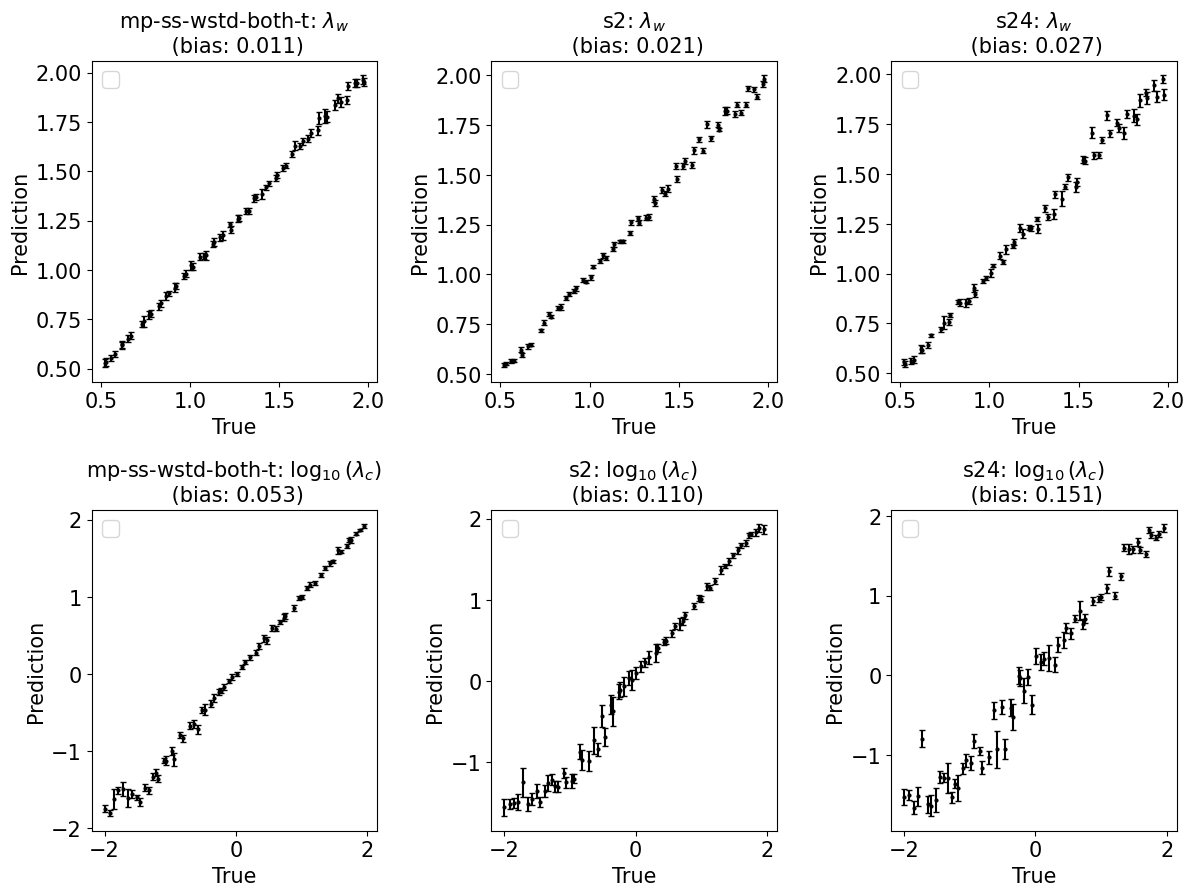

In [15]:
train_or_test = 'test'
# label_set_plot = ['nompR-noss-nowstd-cold', 'nompR-ss-nowstd-warm', 'nompR-ss-nowstd-both', 'nompR-noss-nowstd-cold']
fig, axes = plt.subplots(2, len(label_set), figsize=(14,10))
for i in range(2):
    y_var = y_vars[i]
    for j,model in enumerate(label_set):
        kim = kim_set[j]
        r = results[model]
        ax = axes[i,j]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        std = r['weighted std predict'][train_or_test][...,i]
        bias = r['weighted bias'][train_or_test][i]
        ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
        ax.set(xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
        # ax.set(xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")
        ax.legend()
plt.subplots_adjust(hspace=0.4, wspace=0.4)

## Prediction versus true

KeyError: 'mp-ss-wstd-both'

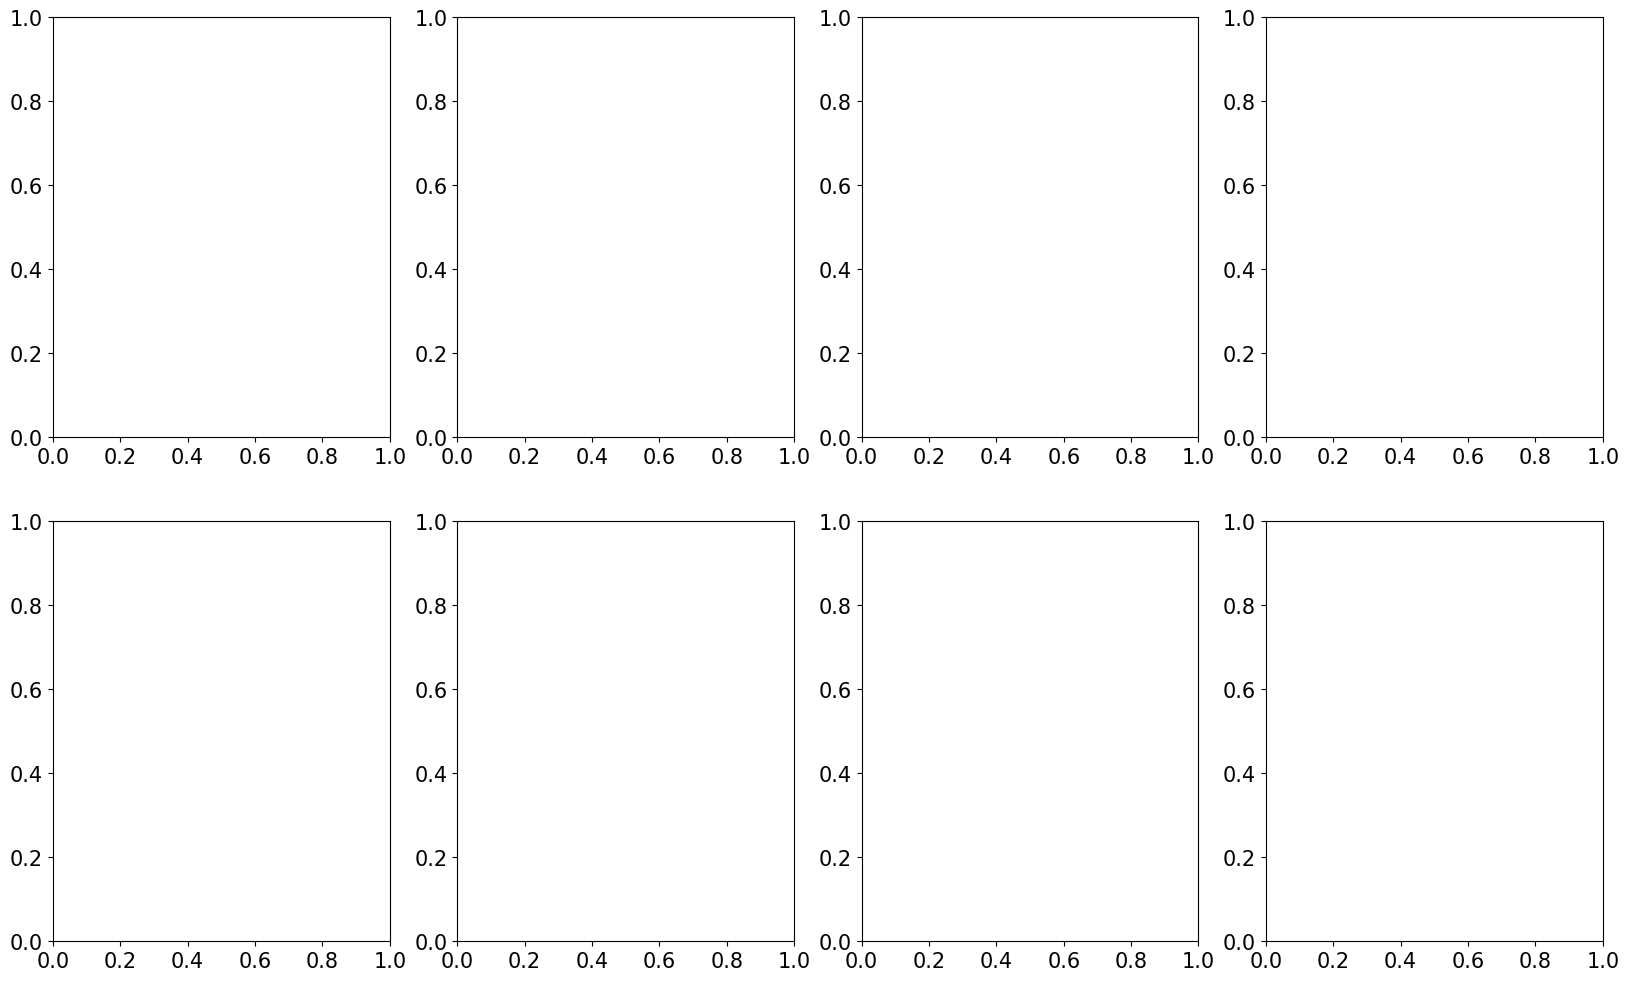

In [47]:
train_or_test = 'test'
# label_set_plot = ['nompR-noss-nowstd-cold', 'nompR-ss-nowstd-warm', 'nompR-ss-nowstd-both', 'nompR-noss-nowstd-cold']
label_set_plot = ['mp-ss-wstd-both', 'nompR-noss-nowstd-warm', 'nompR-noss-nowstd-cold', 'nompR-noss-nowstd-both']
fig, axes = plt.subplots(2,len(label_set_plot),figsize=(20,12))
for i in range(2):
    y_var = y_vars[i]
    for j,model in enumerate(label_set_plot):
        kim = kim_set[j]
        r = results[model]
        ax = axes[i,j]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        std = r['weighted std predict'][train_or_test][...,i]
        bias = r['weighted bias'][train_or_test][i]
        ax.errorbar(x, y, std, color='black', ecolor='grey', linestyle='None', fmt='o', markersize=2, capsize=2)
        lim = ax.get_xlim()
        ax.plot(lim, lim, '--', color='tab:blue')
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{y_var} " + "[W m$^{-2}$]")
        ax.legend()


/tmp/ipykernel_28405/4013852566.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


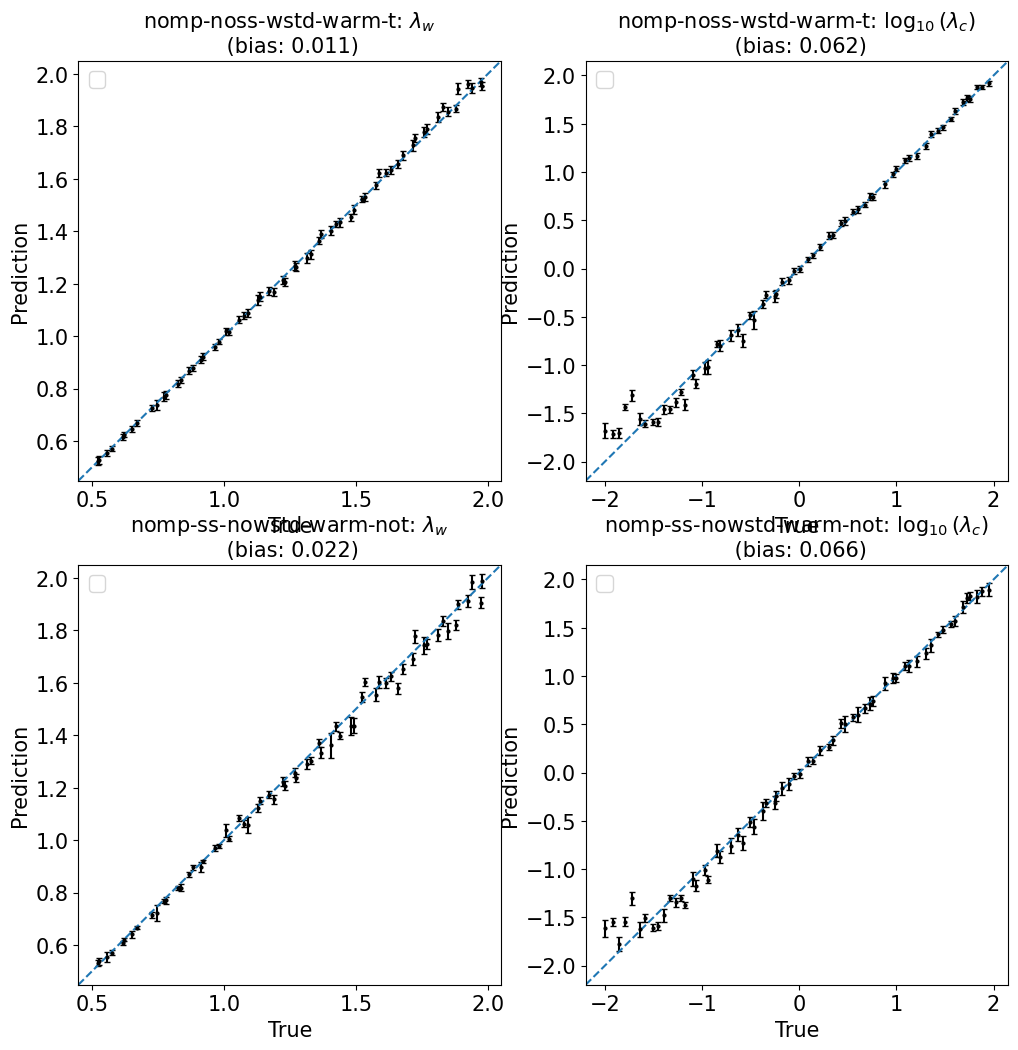

In [55]:
train_or_test = 'test'
label_set_plot = ['nomp-noss-wstd-warm-t', 'nomp-ss-nowstd-warm-not']
fig, axes = plt.subplots(len(label_set_plot),2,figsize=(12,12))
for i in range(2):
    y_var = y_vars[i]
    for j,model in enumerate(label_set_plot):
        kim = kim_set[j]
        r = results[model]
        ax = axes[j,i]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        std = r['weighted std predict'][train_or_test][...,i]
        bias = r['weighted bias'][train_or_test][i]
        ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
        lim = ax.get_xlim()
        ax.plot(lim, lim, '--', color='tab:blue')
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
        ax.legend()


/tmp/ipykernel_28405/2314347058.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


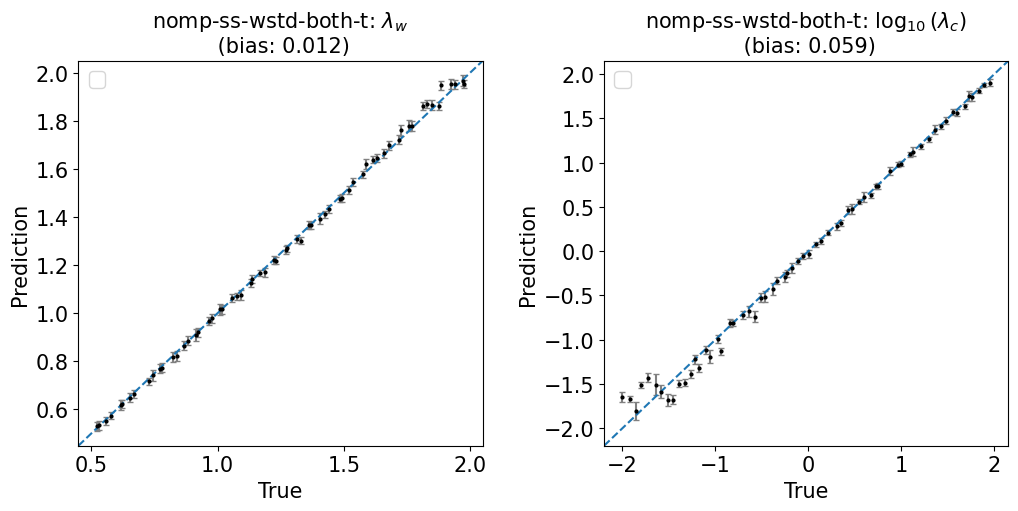

In [53]:
train_or_test = 'test'
model = 'nomp-ss-wstd-both-t'
fig, axes = plt.subplots(1,2,figsize=(12,5))
for i in range(2):
    y_var = y_vars[i]
    r = results[model]
    ax = axes[i]
    x = r['true'][train_or_test][...,i]
    y = r['weighted mean predict'][train_or_test][...,i]
    std = r['weighted std predict'][train_or_test][...,i]
    bias = r['weighted bias'][train_or_test][i]
    ax.errorbar(x, y, std, color='black', ecolor='grey', linestyle='None', fmt='o', markersize=2, capsize=2)
    lim = ax.get_xlim()
    ax.plot(lim, lim, '--', color='tab:blue')
    ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
    ax.legend()
plt.subplots_adjust(wspace=0.3)

/tmp/ipykernel_28405/2235811969.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


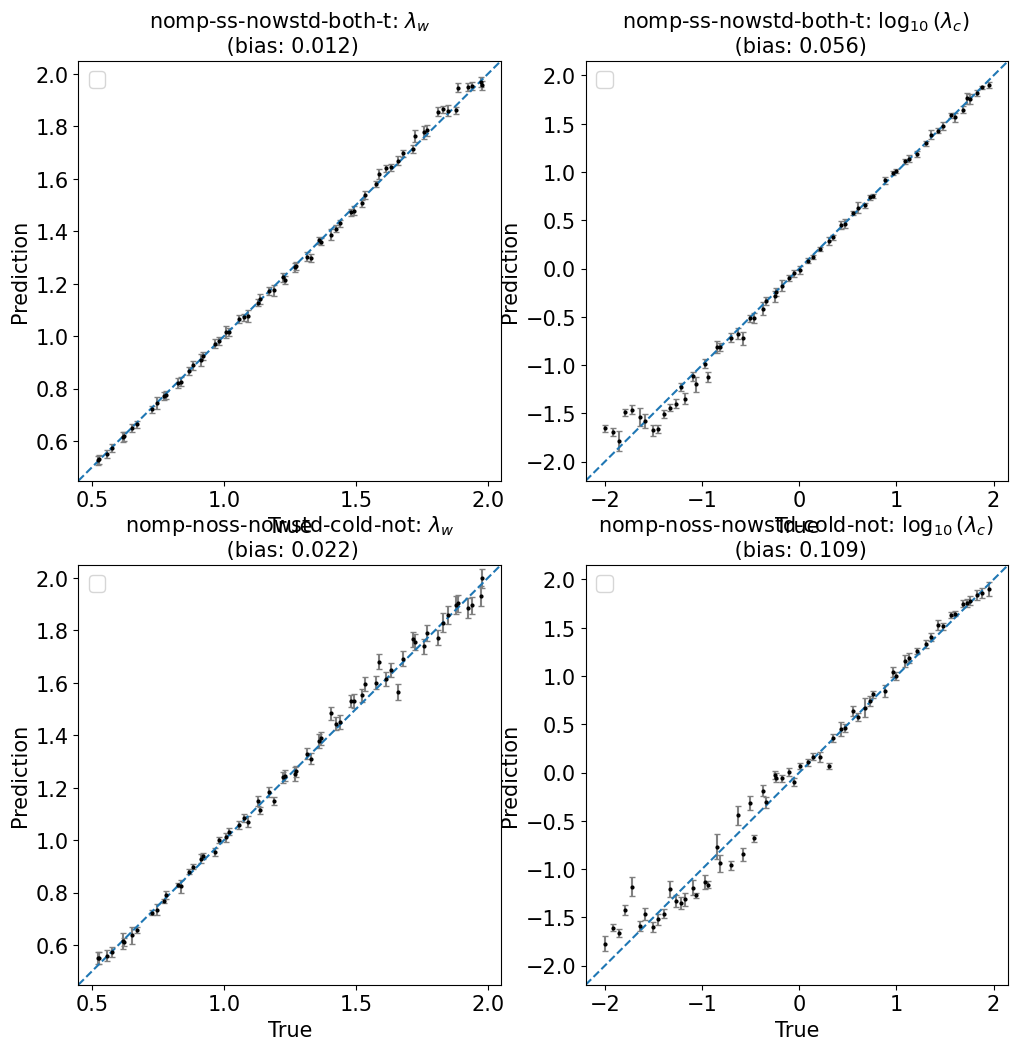

In [54]:
train_or_test = 'test'
label_set_plot = ['nomp-ss-nowstd-both-t', 'nomp-noss-nowstd-cold-not']
fig, axes = plt.subplots(len(label_set_plot),2,figsize=(12,12))
for i in range(2):
    y_var = y_vars[i]
    for j,model in enumerate(label_set_plot):
        kim = kim_set[j]
        r = results[model]
        ax = axes[j,i]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        std = r['weighted std predict'][train_or_test][...,i]
        bias = r['weighted bias'][train_or_test][i]
        ax.errorbar(x, y, std, color='black', ecolor='grey', linestyle='None', fmt='o', markersize=2, capsize=2)
        lim = ax.get_xlim()
        ax.plot(lim, lim, '--', color='tab:blue')
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias:.3f})")
        ax.legend()
